# Nettoyage du jeu de données "Open Facts Food"

In [1]:
# importation des librairies nécessaires

import numpy as np
import pandas as pd
import scipy.stats as stats
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
sns.set_palette("gnuplot2")
sns.set_theme("notebook")

In [3]:
# importation du jeu de données
filename = "openfoodfacts_data.csv"
df = dd.read_csv(filename, dtype='object', sep='\t')

In [4]:
# Transformation du dataframe Dask en dataframe Pandas
df = df.compute()

## 1) Traitement des valeurs manquantes

Toutes les colonnes où on observe un pourcentage supérieur à 75% sont supprimées du jeu de données. 

In [5]:
df = df.loc[:, df.isnull().mean() <.75]

In [6]:
# Affichage du pourcentage de donneés manquantes
df.isnull().mean() * 100

code                                        0.000000
url                                         0.000000
creator                                     0.000218
created_t                                   0.000000
created_datetime                            0.000000
last_modified_t                             0.000000
last_modified_datetime                      0.000000
product_name                                4.284886
quantity                                   74.571574
brands                                     48.276309
brands_tags                                48.279520
categories                                 52.479937
categories_tags                            52.479992
categories_en                              52.479992
countries                                   0.305111
countries_tags                              0.305383
countries_en                                0.305383
ingredients_text                           61.937775
serving_size                               73.

<AxesSubplot:>

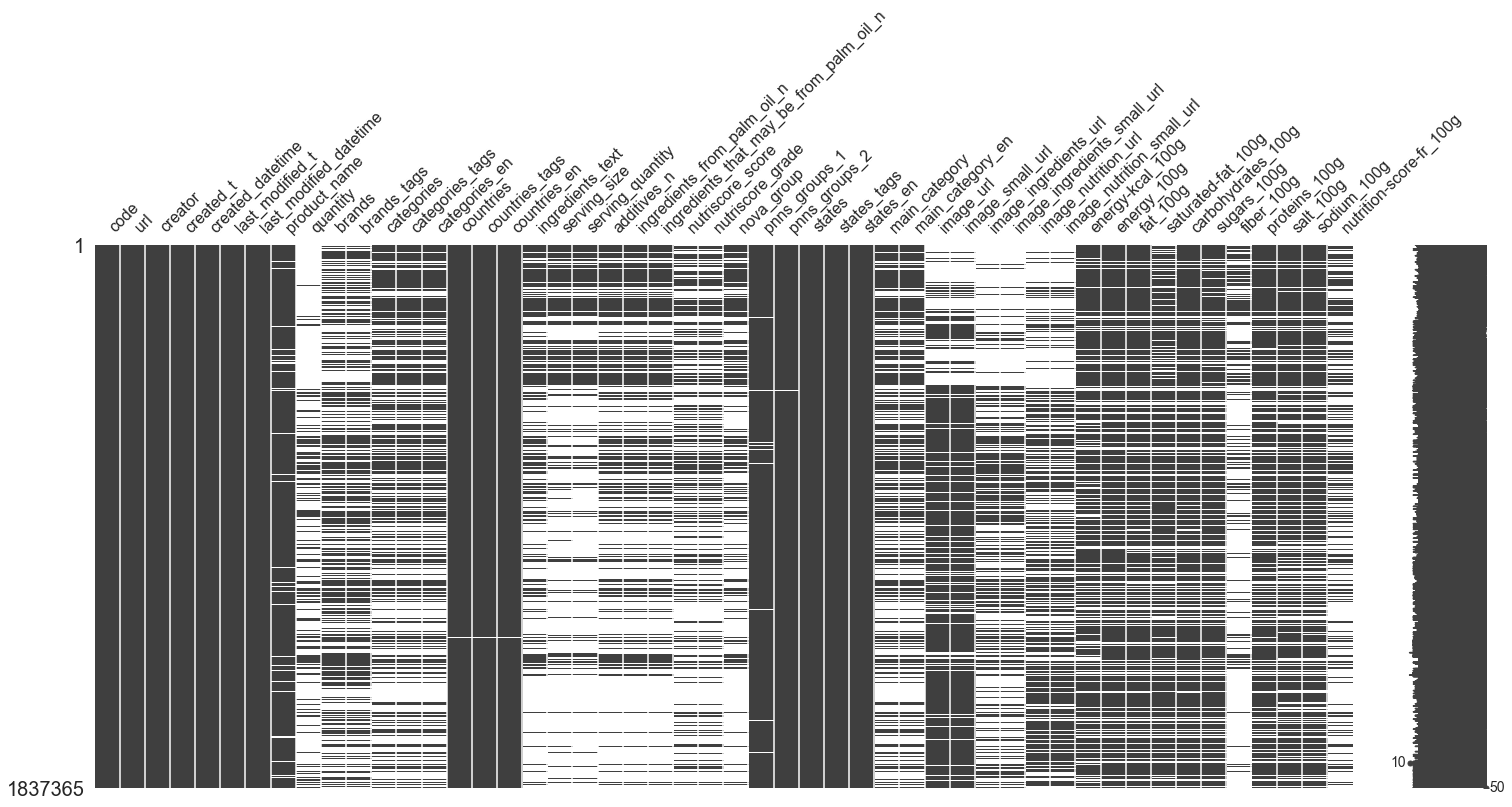

In [7]:
%matplotlib inline
msno.matrix(df)

In [8]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,endives,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,1569,7,3.08,70.1,15,NaN,7.8,1.4,0.56,NaN
2,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,130 g,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000004622327,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1619501895,2021-04-27T05:38:15Z,1619501897,2021-04-27T05:38:17Z,Hamburguesas de ternera 100%,NaN,NaN,...,3661,15.1,6.1,2.6,1,NaN,15.7,2.1,0.84,NaN


## 2) Modification des types

In [9]:
# modification des types du dataset en float quand cela est nécessaire
for col in df.columns:
    if df[col].dtype == object:
        df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='ignore')

In [10]:
col_cat = ["additives_n", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n",
           "nutriscore_score", "nova_group"]

for col in col_cat:
    df[col] = df[col].astype("object")

In [11]:
df["created_datetime"] = pd.to_datetime(df["created_datetime"], format="%Y-%m-%d %H:%M:%S.%f", utc=True)
df['created_date'] = pd.to_datetime(df['created_datetime'], format='%d:%m:%Y').dt.date
df['created_years'] = pd.to_datetime(df['created_datetime'], format='%d:%m:%Y').dt.year

df["last_modified_datetime"] = pd.to_datetime(df["last_modified_datetime"], format="%Y-%m-%d %H:%M:%S.%f", utc=True)
df['last_modified_date'] = pd.to_datetime(df['last_modified_datetime'], format='%d:%m:%Y').dt.date
df['last_modified_years'] = pd.to_datetime(df['last_modified_datetime'], format='%d:%m:%Y').dt.year

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1837365 entries, 0 to 16613
Data columns (total 54 columns):
 #   Column                                   Dtype              
---  ------                                   -----              
 0   code                                     object             
 1   url                                      object             
 2   creator                                  object             
 3   created_t                                int64              
 4   created_datetime                         datetime64[ns, UTC]
 5   last_modified_t                          int64              
 6   last_modified_datetime                   datetime64[ns, UTC]
 7   product_name                             object             
 8   quantity                                 object             
 9   brands                                   object             
 10  brands_tags                              object             
 11  categories                

In [13]:
df.describe()

,created_t,last_modified_t,serving_quantity,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,created_years,last_modified_years
count,1.837365e+06,1.837365e+06,4.756610e+05,1.405073e+06,1.457855e+06,1.449790e+06,1.406180e+06,1.449349e+06,1.432417e+06,475926.000000,1.450905e+06,1.389357e+06,1.389353e+06,677532.000000,1.837365e+06,1.837365e+06
mean,1.554378e+09,1.589384e+09,2.335939e+16,6.250851e+06,4.572169e+36,1.471324e+01,1.226623e+01,2.882682e+01,1.398868e+01,5.135814,8.778622e+00,2.882045e+00,1.152853e+00,9.171624,2.018832e+03,2.019957e+03
std,5.108632e+07,2.937790e+07,1.611049e+19,7.334753e+09,5.520513e+39,8.538600e+02,8.432970e+03,6.434753e+02,8.358298e+02,1449.557263,1.452166e+02,8.593165e+02,3.437268e+02,8.874919,1.628261e+00,9.921528e-01
min,1.328021e+09,1.333873e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-20.000000,-5.000000e+02,0.000000e+00,0.000000e+00,-15.000000,2.012000e+03,2.012000e+03
25%,1.521058e+09,1.579713e+09,2.800000e+01,1.010000e+02,4.180000e+02,7.700000e-01,1.000000e-01,3.500000e+00,6.000000e-01,0.000000,1.300000e+00,7.000000e-02,2.800000e-02,2.000000,2.018000e+03,2.020000e+03
50%,1.565864e+09,1.588793e+09,5.000000e+01,2.610000e+02,1.084000e+03,7.000000e+00,1.800000e+00,1.504425e+01,3.570000e+00,1.600000,6.000000e+00,5.600000e-01,2.240000e-01,10.000000,2.019000e+03,2.020000e+03
75%,1.590926e+09,1.612870e+09,1.130000e+02,4.000000e+02,1.674000e+03,2.140000e+01,7.140000e+00,5.300000e+01,1.800000e+01,3.600000,1.230000e+01,1.400000e+00,5.600000e-01,16.000000,2.020000e+03,2.021000e+03
max,1.624323e+09,1.624323e+09,1.111111e+22,8.693855e+12,6.665559e+42,9.999990e+05,9.999999e+06,7.629390e+05,9.999990e+05,999999.000000,1.730000e+05,9.999990e+05,3.999996e+05,40.000000,2.021000e+03,2.021000e+03


In [14]:
df.shape

(1837365, 54)

Pour finir le traitement des valeurs manquantes, il faudra choisir entre plusieurs méthodes : 
- Enlever les valeurs manquantes (via la méthode dropna)
- Remplacer les valeurs manquantes avec la médiane
- Remplacer les valeurs manquantes avec la moyenne

Avant de procéder à cette étape, on va s'intéresser à deux autres points : le traitement des donneés dupliquées ainsi que l'étude des anomalies.

## 3) Formatage des chaînes de caractères

In [15]:
cols = ["creator", "product_name", "quantity", "brands", "countries", "categories", "ingredients_text",
        "serving_size", "states", "main_category"]

for col in cols:
    if df[col].dtypes == "object":
        df[col] = df[col].str.lower()
        df[col] = df[col].str.capitalize()

## 4) Traitement des données dupliquées

Il y a deux types de données dupliquées : 
- Celles qui correspondent à des colonnes dont les noms sont différents mais donnent la même information (les colonnes _en ou _tags par exemple)
- Celles que l'on peut enlever à l'aide des méthodes. duplicated() et .drop_duplicates()

Dans un premier temps, nous allons nous créer une liste avec les noms des colonnes à supprimer (avec le suffixe _en ou _tags). Ensuite, on cherchera à supprimer les données dupliquées à l'aide des méthodes spécifiques des dataframes Pandas. 

### a) Suppression des colonnes redondantes

In [16]:
drop_cols = ["created_datetime", "last_modified_datetime", "created_t", "last_modified_t", "brands_tags", "categories_tags", "categories_en", "countries_tags", "countries_en", "states_tags", "states_en",
             "main_category_en", "image_small_url", "image_ingredients_small_url", "image_nutrition_small_url", "nutrition-score-fr_100g"]

In [17]:
df.drop(drop_cols, axis=1, inplace=True)

### b) Suppression des informations dupliquées avec .drop_duplicates() et .duplicated()

In [18]:
dupl = df.duplicated()

In [19]:
df_dupl = df[dupl]
df_dupl.head()

,code,url,creator,product_name,quantity,brands,categories,countries,ingredients_text,serving_size,...,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,created_date,created_years,last_modified_date,last_modified_years
18996,7340011495437,http://world-en.openfoodfacts.org/product/7340...,Halal-app-chakib,NaN,NaN,NaN,NaN,Suomi,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-11,2021,2021-01-11,2021


In [20]:
df = df[~dupl]

In [21]:
df.shape

(1837364, 38)

## 5) Détection des anomalies

### a) Visualisation des données pour détecter les anomalies

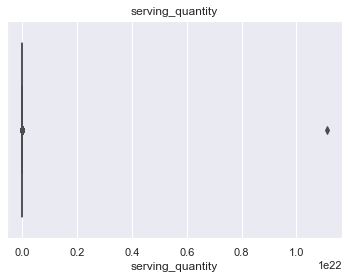

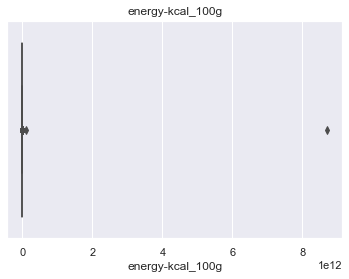

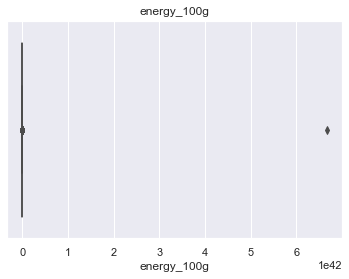

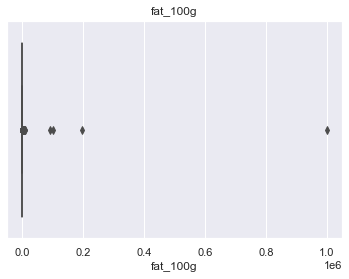

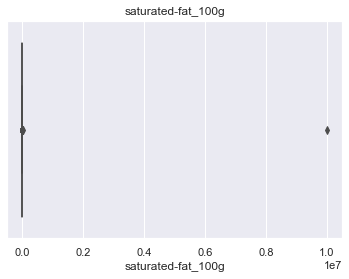

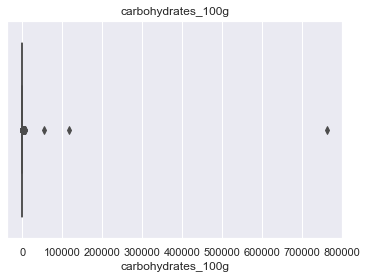

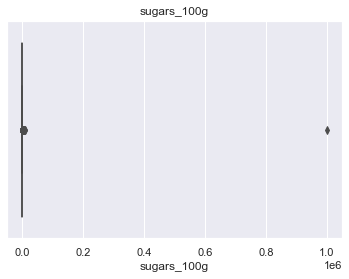

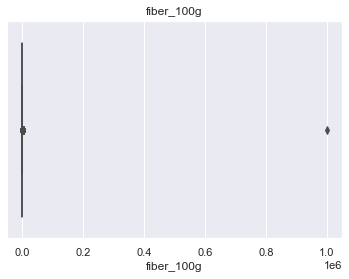

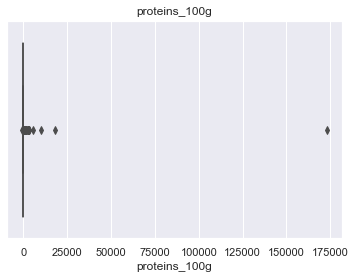

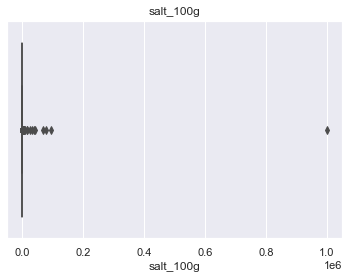

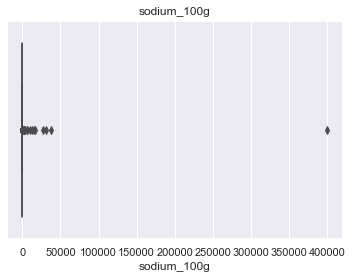

In [22]:
for var in df.columns:
    if df[var].dtypes == 'float64':
        sns.boxplot(x=var, data=df)
        plt.title(var)
        plt.show()

### b) Anomalie liée à la nature des données

Les données nutritives étant pour 100g, elles ne peuvent pas excéder 100g. On va donc supprimer les valeurs superieures à 100g pour les carbohydrates, le sucre, les fibres, les protéines, le sel et le sodium. 

In [23]:
df_clean = df.copy()
cols = ["carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g", "sodium_100g"]

for col in cols:
    mask = df_clean[(df_clean[col] > 0) | (df_clean[col]<100)].index
    df_clean.drop(mask, inplace=True)

KeyboardInterrupt: 

In [ ]:
df_clean.shape

### c) Traitement des outliers à l'aide de la médiane (IQR)

In [ ]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [ ]:
import warnings
warnings.filterwarnings("ignore")

df_clean = df_clean[~((df_clean < lower_bound) | (df_clean> upper_bound)).any(axis=1)]
df_clean.shape

In [ ]:
df_clean.describe()

In [ ]:
for var in df_clean.columns:
    if df_clean[var].dtypes == 'float64':
        sns.boxplot(x=var, data=df_clean)
        plt.title(var)
        plt.show()

## 6) Traitement des valeurs manquantes (suite)

Nos valeurs ont été nettoyées des données aberrantes et on se rend compte que l'index glycémique ne contient qu'une seule valeur. On va donc enlever cette variable de notre étude. Il existe deux variables qui rassemblent les données du nutriscore et elles sont identiques. On va donc en supprimer une pour éviter la redondance dans notre dataset. 

### a) Retrait des valeurs manquantes

In [ ]:
df = df_clean.copy()

In [ ]:
df_clean_no_na = df.dropna()

In [ ]:
%matplotlib inline
msno.matrix(df_clean_no_na)

In [ ]:
df_clean_no_na.describe()

In [ ]:
df_clean_no_na.shape

In [ ]:
df_clean_no_na.to_csv("openfoodfacts_clean.csv", index=False)

On remarque que ce nettoyage produit un jeu de données plus restreint. On peut le sauvegarder pour l'utiliser par la suite. Cependant, le choix de travailler sur un jeu de données où les valeurs manquantes sont remplacées par une autre valeur semble plus judicieux. 

### b) Remplacement des valeurs manquantes par la moyenne

Le choix s'est porté sur une imputation à la moyenne. Les données ont été nettoyées de leurs valeurs extrêmes donc la moyenne ne perdra pas de sa robustesse. 

In [ ]:
df_clean_mean = df.copy()

In [ ]:
for cols in df_clean_mean.columns:
    if df_clean_mean[cols].dtypes == "float64":
        df_clean_mean[cols].fillna(df_clean_mean[cols].mean(), inplace=True)

In [ ]:
df_clean_mean["product_name"].fillna("unknown", inplace=True)
df_clean_mean["countries"].fillna("other", inplace=True)

In [ ]:
df_clean_mean["product_name"].loc[df_clean_mean["product_name"].str.contains('Filet de poulet', case=False, regex=False)] = "Filets de poulet"

In [ ]:
df_clean_mean["countries"].loc[df_clean_mean["countries"].str.contains('France', case=False, regex=False)] = "France"
df_clean_mean["countries"].loc[~df_clean_mean["countries"].str.contains('France', case=False, regex=False)] = "other"

In [ ]:
col_cat = ["additives_n", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n",
           "nutriscore_score", "nova_group"]

for col in col_cat:
    df_clean_mean[col] = df_clean_mean[col].astype("category")

In [ ]:
msno.matrix(df_clean_mean)

In [ ]:
df_clean_mean.describe()

In [ ]:
df_clean_mean.shape

In [ ]:
df_clean_mean.to_csv("openfoodfacts_clean_mean.csv", index=False)